# Random forest machine learning classification of leaf microCT data
#### Semi-automated segmentation of 3D microCT data into multiple classes: (1) background, (2) veins, (3) mesophyll cells, (4) bundle sheath tissue, and (5) intercellular airspace

#### Last edited by: J. Mason Earles 
#### Date: 12/05/2017

In [1]:
# Import libraries
import os
import sklearn as skl
import skimage.io as io
from skimage import img_as_int, img_as_ubyte, img_as_float
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import RFLeafSeg # reload(RFLeafSeg)
from scipy import misc
from skimage.util import invert
from skimage import transform
from sklearn.metrics import confusion_matrix

### Image Loading and Pre-processing

In [2]:
# Set path to tiff stacks
filepath = '../forBeth/'

In [3]:
# Read gridrec, phaserec, and label tif stacks
gridrec_stack = io.imread(filepath + 'V_champ_gridrec.tif')
phaserec_stack = io.imread(filepath + 'V_champ_phaserec.tif')
label_stack = np.rollaxis(io.imread(filepath + 'label_stack_wBS.tif'),2,0)

In [4]:
# # Generate/load local thickness stack
# # Uncomment as needed

# # Generate binary thresholded image for input to local thickness function
# # Set grid and phase threshold values for segmenting low and high absorption regions
# # I typically use Fiji to subjectively and visually determine the 'best' value for each
# Th_grid = -22.92 # grid rec threshold value
# Th_phase = 0.37 # phase rec threshold value
# GridPhase_Bin = RFLeafSeg.Threshold_GridPhase(gridrec_stack, phaserec_stack,Th_grid,Th_phase)

# # Invert image
# GridPhase_Bin_invert = invert(GridPhase_Bin)

# # Downsample to 25%
# GridPhase_Bin_invert = transform.rescale(GridPhase_Bin_invert, 0.25)

# local_thick = RFLeafSeg.local_thickness(GridPhase_Bin_invert)
# local_thick_upscale = transform.rescale(local_thick, 4, mode='reflect')

# # Write as a tif file
# io.imsave('local_thick_upscale.tif', local_thick_upscale)

# Load local thickness stack, if already generated
LocalThickness_CellVeins = io.imread(filepath + 'local_thick_upscale.tif')

In [5]:
# Match array dimensions to correct for resolution loss due to downsampling when generating local thickness
gridrec_stack, local_thick_upscale = RFLeafSeg.match_array_dim(gridrec_stack,LocalThickness_CellVeins)
phaserec_stack, local_thick_upscale = RFLeafSeg.match_array_dim(phaserec_stack,LocalThickness_CellVeins)
label_stack = RFLeafSeg.match_array_dim(label_stack,LocalThickness_CellVeins)[0]

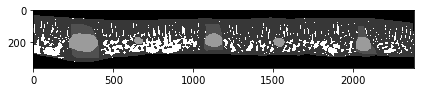

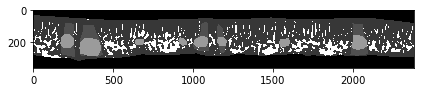

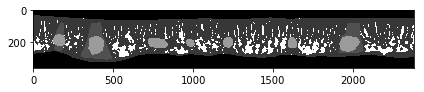

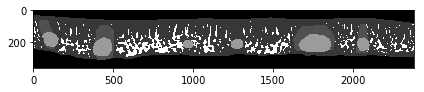

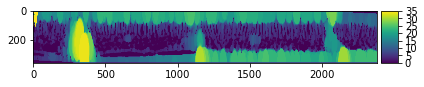

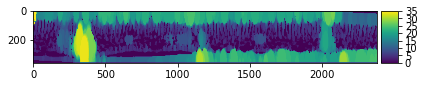

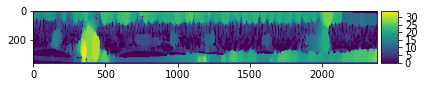

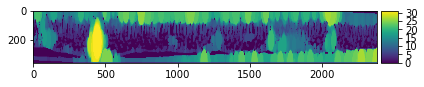

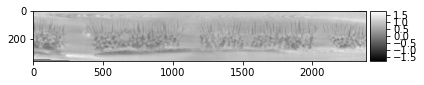

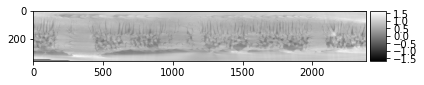

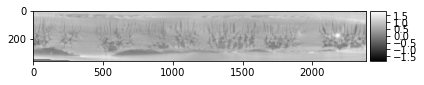

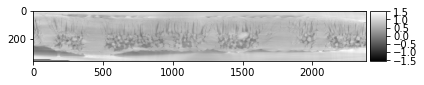

In [7]:
# Plot some of the images to make sure everything looks correct
for i in range(0,4):
    io.imshow(label_stack[i,:,:])
    io.show()

for i in [55,99,160,248]:    
    io.imshow(LocalThickness_CellVeins[i,:,:])
    io.show()
    
for i in [55,99,160,248]:    
    io.imshow(phaserec_stack[i,:,:], cmap='gray')
    io.show()

In [8]:
# Check shapes of stacks to make ensure that they match
print(gridrec_stack.shape)
print(phaserec_stack.shape)
print(label_stack.shape)
print(LocalThickness_CellVeins.shape)

(300, 360, 2384)
(300, 360, 2384)
(4, 360, 2384)
(300, 360, 2384)


In [ ]:
# Define image subsets for training and testing
gridphase_train_slices_subset = [99] # 99 for training of Vitis champ.
gridphase_test_slices_subset = [55,160,248] # 55, 160 and 248 for testing of Vitis champ.
label_train_slices_subset = [1,3] # corresponding slice from the label stack
label_test_slices_subset = [0,2] # corresponding slice from the label stack

In [14]:
# Generate training and testing feature layer array
FL_train_transverse = RFLeafSeg.GenerateFL2(gridrec_stack, phaserec_stack, LocalThickness_CellVeins, gridphase_train_slices_subset, "transverse")
FL_test_transverse = RFLeafSeg.GenerateFL2(gridrec_stack, phaserec_stack, LocalThickness_CellVeins, gridphase_test_slices_subset, "transverse")

In [15]:
# Load and encode label image vectors
Label_train_transverse = RFLeafSeg.LoadLabelData(label_stack, label_train_slices_subset, "transverse")
Label_test_transverse = RFLeafSeg.LoadLabelData(label_stack, label_test_slices_subset, "transverse")

In [16]:
# Check the dimensions of the feature array and label vector to ensure that they are the same dimensions
print(FL_train_transverse.shape)
print(Label_train_transverse.shape)

(1716480, 36)
(1716480,)


### Train model

In [17]:
# Define Random Forest classifier parameters and fit model
rf_transverse = RandomForestClassifier(n_estimators=50, verbose=True, oob_score=True, n_jobs=-1, warm_start=False) #, class_weight="balanced")
rf_transverse = rf_transverse.fit(FL_train_transverse, Label_train_transverse)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.5min finished


In [ ]:
# Save model to disk # This can be a pretty large file -- ~2 Gb
# import pickle
# filename = 'RF_Vitus_champ_model.sav'
# pickle.dump(rf_transverse, open(filename, 'wb'))

#load the model from disk
#rf = pickle.load(open(filename, 'rb'))

### Examine prediction metrics on training dataset

In [18]:
# Print out of bag precition accuracy
print('Our out-of-bag (OOB) prediction of accuracy for is: {oob}%'.format(oob=rf_transverse.oob_score_ * 100))

Our out-of-bag (OOB) prediction of accuracy for is: 99.8538870246%


In [19]:
# Print feature layer importance
# See RFLeafSeg module for corresponding feature layer types
feature_layers = range(0,len(rf_transverse.feature_importances_))
for fl, imp in zip(feature_layers, rf_transverse.feature_importances_):
    print('Feature_layer {fl} importance: {imp}'.format(fl=fl, imp=imp))
#print('none')

Feature_layer 0 importance: 0.03458962395
Feature_layer 1 importance: 0.0745966480364
Feature_layer 2 importance: 0.00462485874374
Feature_layer 3 importance: 0.0320936882435
Feature_layer 4 importance: 0.0149826249665
Feature_layer 5 importance: 0.0151620617682
Feature_layer 6 importance: 0.00205502129949
Feature_layer 7 importance: 0.00315320118484
Feature_layer 8 importance: 0.00338162997379
Feature_layer 9 importance: 0.00729013724409
Feature_layer 10 importance: 0.0115887836897
Feature_layer 11 importance: 0.00871261433154
Feature_layer 12 importance: 0.0489358718201
Feature_layer 13 importance: 0.0189481385359
Feature_layer 14 importance: 0.0555807823655
Feature_layer 15 importance: 0.137450163176
Feature_layer 16 importance: 0.0133056122064
Feature_layer 17 importance: 0.0505226419125
Feature_layer 18 importance: 0.00897576497392
Feature_layer 19 importance: 0.0133330264528
Feature_layer 20 importance: 0.000436003068605
Feature_layer 21 importance: 0.00222515133485
Feature_layer

### Predict single slices from test dataset

In [20]:
# Make prediction on test set
class_prediction_transverse = rf_transverse.predict(FL_test_transverse)
class_prediction_transverse_prob = rf_transverse.predict_proba(FL_test_transverse)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.2s finished


In [21]:
# Generate confusion matrix for transverse section
cf_mat1 = pd.crosstab(Label_test_transverse, class_prediction_transverse, rownames=['Actual'], colnames=['Predicted'])

In [22]:
# Generate normalized confusion matrix for transverse section
pd.crosstab(Label_test_transverse, class_prediction_transverse, rownames=['Actual'], colnames=['Predicted'], normalize='index')

Predicted,0,1,2,3,4
Actual,,,,,
0,0.956340,0.040451,0.000000,0.000000,0.003208
1,0.040090,0.953774,0.003669,0.002461,0.000006
2,0.009167,0.389213,0.357848,0.241586,0.002187
3,0.000000,0.230410,0.171270,0.597676,0.000644
4,0.003615,0.000181,0.000187,0.000000,0.996018


In [24]:
class_prediction_transverse2 = np.copy(class_prediction_transverse)
class_prediction_transverse2[class_prediction_transverse==1] = 2
#class_prediction_transverse2[class_prediction_transverse2==3] = 4
Label_test_transverse2 = np.copy(Label_test_transverse)
Label_test_transverse2[Label_test_transverse==1] = 2
#Label_test_transverse2[Label_test_transverse2==3] = 4
pd.crosstab(Label_test_transverse2, class_prediction_transverse2, rownames=['Actual'], colnames=['Predicted'], normalize='index')
cf_mat2 = pd.crosstab(Label_test_transverse2, class_prediction_transverse2, rownames=['Actual'], colnames=['Predicted'])
print(cf_mat2)

Predicted       0       2      3       4
Actual                                  
0          576767   24396      0    1935
2           32867  820203  18109     151
3               0   30557  45467      49
4             600      61      0  165318


In [25]:
# Total accuracy
print(float(np.diag(cf_mat2).sum())/float(cf_mat2.sum().sum()))

# Class precision
print(np.diag(cf_mat2)/np.sum(cf_mat2,1), "precision")

# Class recall
print(np.diag(cf_mat2)/np.sum(cf_mat2,0), "recall")

0.936658160887
(Actual
0    0.956340
2    0.941323
3    0.597676
4    0.996018
dtype: float64, 'precision')
(Predicted
0    0.945157
2    0.937142
3    0.715160
4    0.987250
dtype: float64, 'recall')


In [27]:
# Reshape arrays for plotting images of class probabilities, predicted classes, observed classes, and feature layer of interest
prediction_transverse_prob_imgs = class_prediction_transverse_prob.reshape((
    -1,
    label_stack.shape[1],
    label_stack.shape[2],
    5),
    order="F")
prediction_transverse_imgs = class_prediction_transverse.reshape((
    -1,
    label_stack.shape[1],
    label_stack.shape[2]),
    order="F")
observed_transverse_imgs = Label_test_transverse.reshape((
    -1,
    label_stack.shape[1],
    label_stack.shape[2]),
    order="F")
FL_transverse_imgs = FL_test_transverse.reshape((
    -1,
    label_stack.shape[1],
    label_stack.shape[2],
    36),
    order="F")

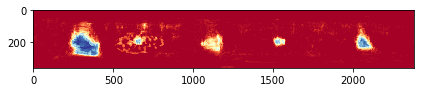

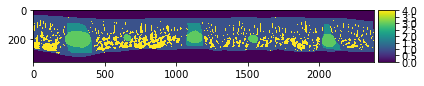

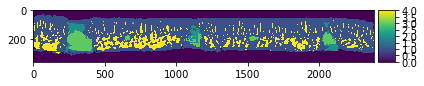

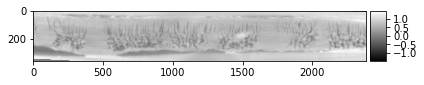

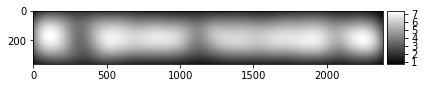

In [30]:
# Plot images of class probabilities, predicted classes, observed classes, and feature layer of interest
%matplotlib inline
for i in range(0,1):
    io.imshow(prediction_transverse_prob_imgs[i,:,:,3], cmap="RdYlBu")
    io.show()
    io.imshow(observed_transverse_imgs[i,:,:])
    io.show()
    io.imshow(prediction_transverse_imgs[i,:,:])
    io.show()
    io.imshow(phaserec_stack[260,:,:], cmap="gray")
    io.show()
    io.imshow(FL_transverse_imgs[0,:,:,26], cmap="gray")
    io.show()

### Predict all slices in 3D microCT stack

In [ ]:
# Predict all slices in 3D microCT stack
RFPredictCTStack_out = RFLeafSeg.RFPredictCTStack(rf_transverse,gridrec_stack, phaserec_stack, LocalThickness_CellVeins,"transverse")

### Calculate performance metrics

In [32]:
# Performance metrics
test_slices = (55,160)
label_slices = (0,2)

# Generate absolute confusion matrix
confusion_matrix = pd.crosstab(RFPredictCTStack_out[test_slices,:,:].ravel(order="F"),
                               label_stack[label_slices,:,:].ravel(order="F"),
                               rownames=['Actual'], colnames=['Predicted'])

# Generate normalized confusion matrix
confusion_matrix_norm = pd.crosstab(RFPredictCTStack_out[test_slices,:,:].ravel(order="F"),
                               label_stack[label_slices,:,:].ravel(order="F"),
                               rownames=['Actual'], colnames=['Predicted'])

# Total accuracy
print(np.diag(confusion_matrix).sum()/RFPredictCTStack_out[test_slices,:,:].sum())

# Class precision
print(np.diag(confusion_matrix)/np.sum(confusion_matrix,1), "precision")

# Class recall
print(np.diag(confusion_matrix)/np.sum(confusion_matrix,0), "recall")

### Save segmented and classified stack as TIFF file

In [ ]:
# Save classified stack
io.imsave('Vitis_champ_Predicted_wBS.tif',img_as_int(RFPredictCTStack_out/6))